# Lab 3: Gesture Recognition using Convolutional Neural Networks



In [ ]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/APS360\ Lab_3_Gesture_Recognition.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/APS360 Lab_3_Gesture_Recognition.ipynb to html
[NbConvertApp] Writing 1268455 bytes to /content/drive/MyDrive/Colab Notebooks/APS360 Lab_3_Gesture_Recognition.html


## Colab Link

Include a link to your colab file here

Colab Link: [https://colab.research.google.com/drive/1EzNqcLwvdxwqOcBpAkJI_d65TYCwg7Qg?usp=sharing](https://colab.research.google.com/drive/1EzNqcLwvdxwqOcBpAkJI_d65TYCwg7Qg?usp=sharing)


## Part A. Data Collection [10 pt]


## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
) 

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt

In [ ]:
# Import google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Unzip gesture images
!unzip '/content/drive/My Drive/Colab Notebooks/Lab_3_Gesture_Dataset.zip' -d '/root/datasets'

In [ ]:
def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

In [ ]:
def get_data_loader(target_classes, batch_size, path):
  # Some important constants...
  data_dir = path
  classes = ['A','B','C','D','E','F','G','H','I']
  np.random.seed(1000)

  # Make sure everything is 224x224, mostly because I'm an idiot and 
  # uploaded 244x244 images instead 
  transformation = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])

  # all_images contains the entire data set, but we want to segment it 
  # out into training, validation, and testing...
  trainset = datasets.ImageFolder(data_dir, transform=transformation)

  # Let's start by getting all of the indices of the images and then randomly
  # assigning them to train, val, and test
  relevant_indices = get_relevant_indices(trainset, classes, target_classes)
  np.random.shuffle(relevant_indices)
  split = int(len(relevant_indices) * 0.6)
  split_2 = int(len(relevant_indices) * 0.2) + split

  # We want a 60% training set, 20% validation set, and 20% testing set....
  # Split into training and validation indices  
  relevant_train_indices  = relevant_indices[:split]
  relevant_val_indices = relevant_indices[split:split_2]  
  relevent_test_indices = relevant_indices[split_2:]

  # Get the training samples
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                             num_workers =1, sampler=train_sampler)
  
  # Get the validation samples
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                             num_workers =1, sampler=val_sampler)
  
  # Get the testing samples
  test_sampler = SubsetRandomSampler(relevent_test_indices)
  test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                             num_workers =1, sampler=test_sampler)
  
  return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_data_loader(['A','B','C','D','E','F','G','H','I'], 32, '/root/datasets/Lab_3b_Gesture_Dataset')

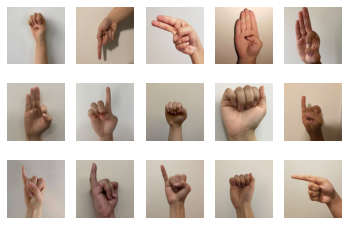

In [ ]:
# Make sure that our data loader worked...
k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

### CNN architecture:
As a starting point I used a simple 2 convolution layers with 2 
linear classification layers. This was based off the work we did in turorial. However, the results were less than ideal. So I decided to redo the parameters for the convolution layers...
<br><br>
Before creating the architecture I did some research to see what other models have been made. I found paper titled "A Deep Convolutional Neural Network Approach for Static Hand Gesture Recognition", which seeks to do exactly what we are tasked with. In there paper they used 3 convolutional layers, with max pooling, then several linear fully connected layers with relu. However, there dataset is far more cluttered (they have different backgrounds etc...) so it that could be the reason why they needed so many layers. In any case I will use the findings from there paper to base my CNN architecture off of.  
<br>
In the paper they used a 19x19 filter with 8 outputs, then a 17x17 filter with 16 outputs, then a 15x15 filter with 32 outputs. The pooling was done with a 2x2 kernel size and a stride of 3. Lastly, it wasn't specified so I just used two fully connected linear layers that consolidated the output from the convolution layers. I followed what the paper proposed because in there findings they were able to achieve a 97% accuracy on there testing set. As for activation functions, using Relu is generally standard practice, and since we don't care about negative values it's makes sense it this context.   


References:
<br>
A. V. and R. R., “A deep convolutional neural network approach for static hand gesture recognition,” *Procedia Computer Science*, vol. 171, pp. 2353–2361, 2020.




  


In [ ]:
class CNN(nn.Module) :
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 8, 19)
    self.conv2 = nn.Conv2d(8, 16, 17)
    self.conv3 = nn.Conv2d(16, 32, 15)
    self.pool = nn.MaxPool2d(2, 3)
    self.fc1 = nn.Linear(32, 16)
    self.fc2 = nn.Linear(16, 9) 
    self.name = 'CNN'
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 32)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

### Training the CNN: 
For this model it makes sense to use a torch.nn.CrossEntropyLoss because it implements a logistic soft max loss function: <br>
### $P_r\{y_n = i | x_n\} = \frac{e^{w_i x_n}}{\sum_{j=1}^{c}e^{w_j^T x_n}}$
which will provide us a probabilistic outcome for how likely the sample it to be one of the nine letters. So, by using this loss function we can see how likely a sample is to lie in a specific classification, which makes it easy to find out where our model fall short and how we can improve. For example, when a sample is classified as B but is labeled as A we can check the probability distribution and see how close we were to the correct classification. 
<br>
One small note is that I decided to use stochastic gradient descent, but after finishing the lab I think that using ADAM might have been more efficient. 



In [ ]:
def get_accuracy(model, train=False):
    if train == True:
        data = train_loader
    else:
        if train == False:
          data = val_loader
        else:
          data = test_loader

    correct = 0
    total = 0
    for i, info in enumerate(data, 0):
        
        imgs, labels = info

        if torch.cuda.is_available() :
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        print(pred, labels, output)
    return correct / total

In [ ]:
def train(model, path, batch_size=64, num_epochs=5, learning_rate=0.01):
  if model.name == "alexCNN":
    train_loader, val_loader, test_loader = get_alex_data_loader(['A','B','C','D','E','F','G','H','I'], batch_size, path)
  else:
    train_loader, val_loader, test_loader = get_data_loader(['A','B','C','D','E','F','G','H','I'], batch_size, path)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  torch.manual_seed(1000)
  model_name = model.name  + '_lr_' +  str(learning_rate) + '_bs_' + str(batch_size) + '_epc_' + str(num_epochs) + '.pt'
  PATH = '/content/drive/MyDrive/Colab Notebooks/Model checkpoint/' + model_name

  iters, losses, train_acc, val_acc = [], [], [], []

  # training
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    for i, data in enumerate(train_loader, 0):

      # Get the inputs and lables
      inputs, labels = data

      if torch.cuda.is_available() :
        inputs = inputs.cuda()
        labels = labels.cuda()
        
      output = model(inputs)             # forward pass
      # break

      loss = criterion(output, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # a clean up step for PyTorch

      # save the current training information
      iters.append(n)
      losses.append(float(loss)/batch_size)             # compute *average* loss
      train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
      val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
      
      n += 1
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': losses[-1],
            }, PATH)

  
  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  return losses, train_acc, val_acc

In [ ]:
train_loader, val_loader, test_loader = get_data_loader(['A','B','C','D','E','F','G','H','I'], 512, '/root/datasets/Lab_3b_Gesture_Dataset')

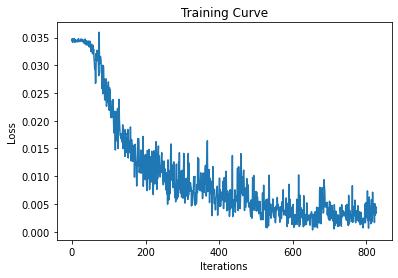

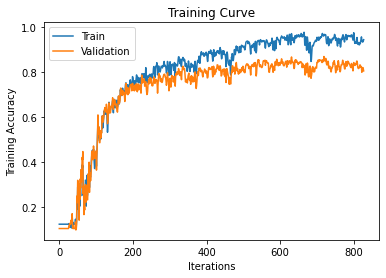

In [ ]:
# Example of using the training loop
train_loader, val_loader, test_loader = get_data_loader(['A','B','C','D','E','F','G','H','I'], 256, '/root/datasets/Lab_3b_Gesture_Dataset')
model = CNN()

if torch.cuda.is_available():
  model.cuda()

loss, train_acc, val_acc = train(model, train_loader, batch_size=64, num_epochs=36, learning_rate=0.01)

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
# Unzip my own small ASL dataset
!unzip '/content/drive/My Drive/Colab Notebooks/Small data gestures.zip' -d '/root/datasets'

In [ ]:
def smalltest(num_epochs=180, learning_rate=0.01, batch_size=27):
  # Some important constants...
  model = CNN()

  if torch.cuda.is_available(): 
    model.cuda()
    
  data_dir = '/root/datasets/Small data gestures'
  classes = ['A','B','C','D','E','F','G','H','I']
  np.random.seed(1000)

  # Make sure everything is 224x224, mostly because I'm an idiot and 
  # uploaded 244x244 images instead 
  transformation = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])

  # all_images contains the entire data set, but we want to segment it 
  # out into training, validation, and testing...
  trainset = datasets.ImageFolder(data_dir, transform=transformation)

  # Let's start by getting all of the indices of the images and then randomly
  # assigning them to train, val, and test
  relevant_indices = get_relevant_indices(trainset, classes, classes)
  np.random.shuffle(relevant_indices)

  # We want a 60% training set, 20% validation set, and 20% testing set....
  # Split into training and validation indices  
  relevant_train_indices  = relevant_indices

  # Get the training samples
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=27, 
                                             num_workers =1, sampler=train_sampler)
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  torch.manual_seed(1000)

  iters, losses, train_acc= [], [], []

  # training
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
      print("Epoch: ", epoch)
      for i, data in enumerate(train_loader, 0):

          # Get the inputs and lables
          inputs, labels = data

          if torch.cuda.is_available() :
            inputs = inputs.cuda()
            labels = labels.cuda()
            
          out = model(inputs)             # forward pass

          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch

          # save the current training information
          iters.append(n)
          losses.append(float(loss)/batch_size)             # compute *average* loss
          train_acc.append(get_accuracy(model, train=True)) # compute training accuracy 
          
          n += 1
  
  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

In [ ]:
# Now train the model to make it over fit
smalltest()

It works!


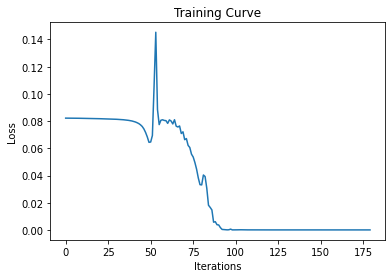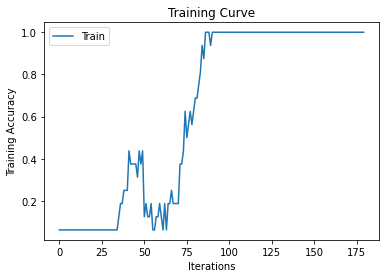

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

I think that the learning rate, batch size, and the pooling stride size.

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
# Batch size hyperparameter:
model = CNN()
batch_sizes = [32, 64, 128, 256]

if torch.cuda.is_available():
  model.cuda()

for b in batch_sizes: 
  loss, train_acc, val_acc  = train(model, '/root/datasets/Lab_3b_Gesture_Dataset', batch_size=b, num_epochs=30, learning_rate=0.01)
  print("Max training accuracy", max(train_acc))
  print("Max validation accuracy", max(val_acc))

#### Batch size hyperparameter results:
Shown below is the loss and accuracy graphs for batch sizes 256, 128, 64, and 32 respectively.
*italicized text*

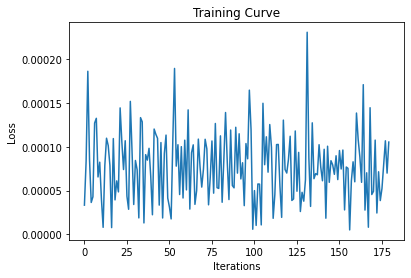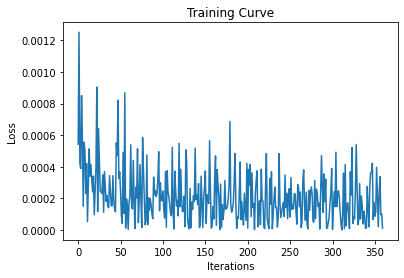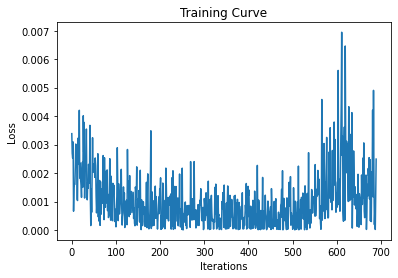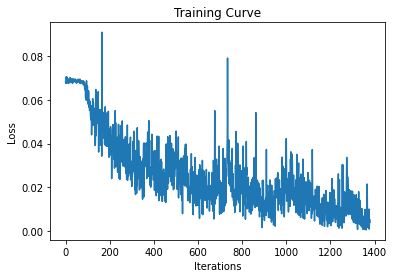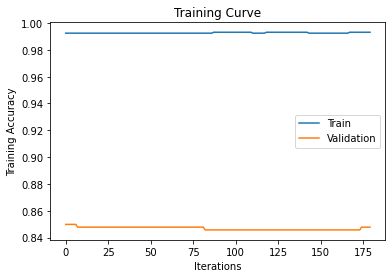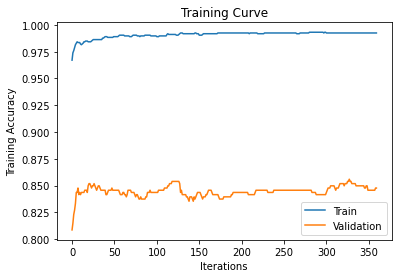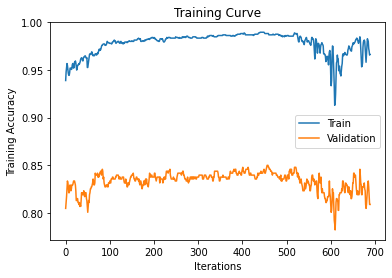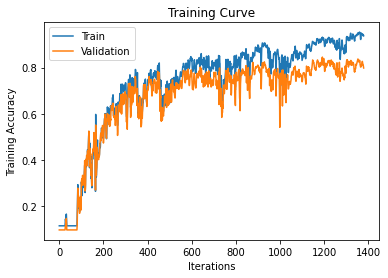



From the above graphs the best batch size is 32, it achived a maximum of 84% validation accuracy. 

In [ ]:
# Learning rate hyperparameter
model = CNN()
train_loader, val_loader, test_loader = get_data_loader(['A','B','C','D','E','F','G','H','I'], 64, '/root/datasets/Lab_3b_Gesture_Dataset')
learning_rates = [0.01, 0.005, 0.001]

if torch.cuda.is_available():
  model.cuda()

for lr in learning_rates: 
  loss, train_acc, val_acc = train(model, '/root/datasets/Lab_3b_Gesture_Dataset', batch_size=64, num_epochs=30, learning_rate=lr)
  print("Max training accuracy", max(train_acc))
  print("Max validation accuracy", max(val_acc))

#### Learning rate hyperparameter results:
Shown below are the loss and accuracy graphs for learning rates 0.01, 0.005, and 0.001 respectively

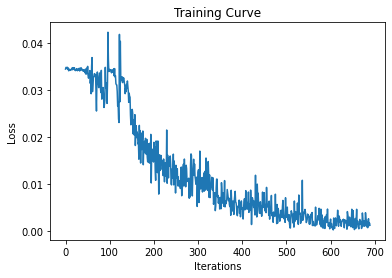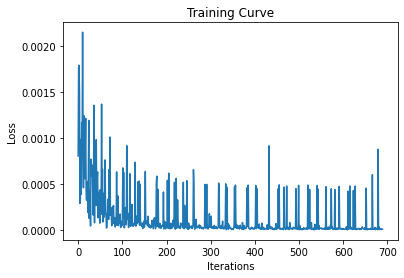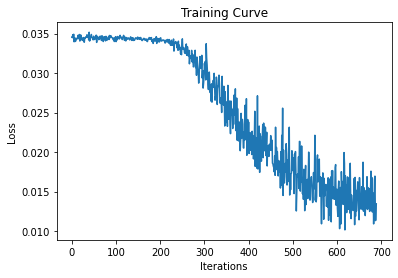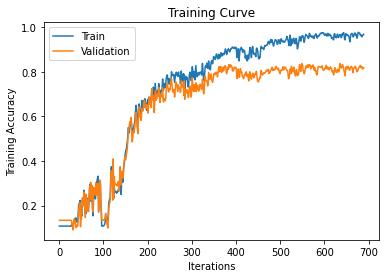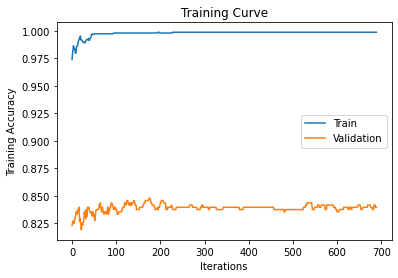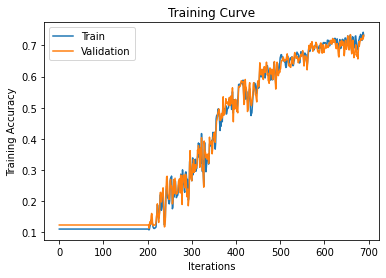

In [ ]:
class PoolStride_2(nn.Module) :
  def __init__(self):
    super(PoolStride_2, self).__init__()
    self.conv1 = nn.Conv2d(3, 8, 19)
    self.conv2 = nn.Conv2d(8, 16, 17)
    self.conv3 = nn.Conv2d(16, 32, 15)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(32*14*14, 16)
    self.fc2 = nn.Linear(16, 9) 
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 32*14*14)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
# Pool stride size hyperparameter
model = PoolStride_2()
train_loader, val_loader, test_loader = get_data_loader(['A','B','C','D','E','F','G','H','I'], 64, '/root/datasets/Lab_3b_Gesture_Dataset')

if torch.cuda.is_available():
  model.cuda()

loss, train_acc, val_acc = train(model, '/root/datasets/Lab_3b_Gesture_Dataset', batch_size=64, num_epochs=30, learning_rate=0.01)

In [ ]:
class PoolStride_1(nn.Module) :
  def __init__(self):
    super(PoolStride_1, self).__init__()
    self.conv1 = nn.Conv2d(3, 8, 19)
    self.conv2 = nn.Conv2d(8, 16, 17)
    self.conv3 = nn.Conv2d(16, 32, 15)
    self.pool = nn.MaxPool2d(2, 1)
    self.fc1 = nn.Linear(32*173*173, 16)
    self.fc2 = nn.Linear(16, 9) 
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = x.view(-1, 32*173*173)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
# Pool stride size hyperparameter
model = PoolStride_1()
train_loader, val_loader, test_loader = get_data_loader(['A','B','C','D','E','F','G','H','I'], 64, '/root/datasets/Lab_3b_Gesture_Dataset')

if torch.cuda.is_available():
  model.cuda()

loss, train_acc, val_acc = train(model, '/root/datasets/Lab_3b_Gesture_Dataset', batch_size=64, num_epochs=25, learning_rate=0.01)

Shown below are the loss and accuracy graphs for using a stride size of 1 and 2 respectively. Turns out that chaning the stride size isn't a good idea!


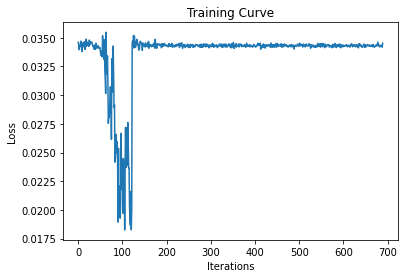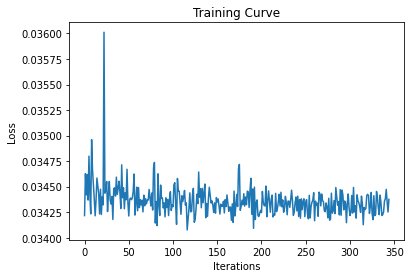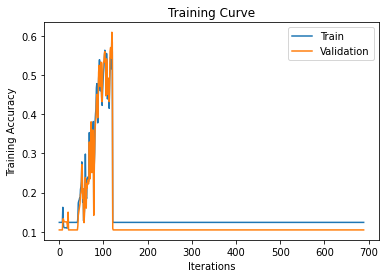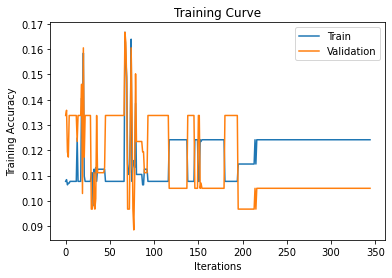

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

#### Best parameters:
From my results I found that using a batch size of between 32-64 yields the best results because it doen't overfit the model too much and it ensure that it doesn't get underfitted. Again our original parameters seem to be working, as such keeping the learning rate at 0.01 yields higher accuracy and ensures the model isn't underfit. As for stride size, using a stride of 3 yielded terrible results, and using a stride of 1 was far too taxing on the GPUs, as such sticking with a stride of 3 looks to be the correct course of action. 

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

The test accuracy I got was 77.2%

In [ ]:
# Train the model with the best parameters
model = CNN()
train_loader, val_loader, test_loader = get_data_loader(['A','B','C','D','E','F','G','H','I'], 32, '/root/datasets/Lab_3b_Gesture_Dataset')

if torch.cuda.is_available():
  model.cuda()

loss, train_acc, val_acc = train(model, '/root/datasets/Lab_3b_Gesture_Dataset', batch_size=32, num_epochs=30, learning_rate=0.01)

In [ ]:
# Load the saved model and test the accuracy on the testing data
model = CNN()
if torch.cuda.is_available():
  model.cuda()

checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Model checkpoint/CNNlr_0.01_bs_32_epc_30.pt')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(get_accuracy(model, train=True))
print(get_accuracy(model, train=False))
print(get_accuracy(model, train='Test'))

0.8930041152263375
0.7880658436213992
0.7720739219712526


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
k = 0
for img, labels in train_loader:
    features = alexnet.features(img)
    break

In [ ]:
# Save the computed features onto disk because they take up waaayyyy too much space
# in memory, and actually cause colab to exceed the amount of allocated RAM
def alexnet_features(batch_size=64, path='/root/datasets/Lab_3b_Gesture_Dataset', save_path='/content/drive/MyDrive/Colab Notebooks/Alex features/'):
  classes = ['A','B','C','D','E','F','G','H','I']

  train_loader, val_loader, test_loader = get_data_loader(['A','B','C','D','E','F','G','H','I'], batch_size, path)

  # For each input and label batch run it through the alexnet features
  folder = save_path 
  i = 0

  for i, data in enumerate(train_loader, 0) :
    input, label = data

    train_features = alexnet.features(input)
    feature = torch.from_numpy(train_features.detach().numpy())

    sample_path = folder + str(classes[label]) 
    if not os.path.isdir(sample_path):
      os.mkdir(sample_path) 

    torch.save(feature.squeeze(0), sample_path + '/' + str(i) + "_" + classes[label] + '.tensor')
    i+=1


  # For each input and label batch run it through the alexnet features
  for i, data in enumerate(val_loader, 0) :
    input, label = data

    validation_features = alexnet.features(input)
    features = torch.from_numpy(validation_features.detach().numpy())

    sample_path = folder + str(classes[label]) 
    if not os.path.isdir(sample_path):
      os.mkdir(sample_path) 

    torch.save(features.squeeze(0), sample_path + '/' + str(i) + "_" + classes[label] + '.tensor')
    i+=1
  
  for i, data in enumerate(test_loader, 0) :
    input, label = data

    test_features = alexnet.features(input)
    features = torch.from_numpy(test_features.detach().numpy())

    sample_path = folder + str(classes[label]) 
    if not os.path.isdir(sample_path):
      os.mkdir(sample_path) 

    torch.save(features.squeeze(0), sample_path + '/' + str(i) + "_" + classes[label] + '.tensor')
    i+=1

  return



In [ ]:
# Basically the same as get_data_loader but now instead of grabbing images
# from our drive, we grab the features outputed by alex net
def get_alex_data_loader(target_classes, batch_size, path):
  # Some important constants...
  data_dir = path
  classes = ['A','B','C','D','E','F','G','H','I']
  np.random.seed(1000)

  # all_images contains the entire data set, but we want to segment it 
  # out into training, validation, and testing...
  trainset = datasets.DatasetFolder(data_dir, extensions=('.tensor'), loader=torch.load)

  # Let's start by getting all of the indices of the images and then randomly
  # assigning them to train, val, and test
  relevant_indices = get_relevant_indices(trainset, classes, target_classes)
  np.random.shuffle(relevant_indices)
  split = int(len(relevant_indices) * 0.6)
  split_2 = int(len(relevant_indices) * 0.2) + split

  # We want a 60% training set, 20% validation set, and 20% testing set....
  # Split into training and validation indices  
  relevant_train_indices  = relevant_indices[:split]
  relevant_val_indices = relevant_indices[split:split_2]  
  relevent_test_indices = relevant_indices[split_2:]

  # Get the training samples
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                             num_workers =0, sampler=train_sampler)
  
  # Get the validation samples
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                             num_workers =0, sampler=val_sampler)
  
  # Get the testing samples
  test_sampler = SubsetRandomSampler(relevent_test_indices)
  test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                             num_workers =0, sampler=test_sampler)
  
  return train_loader, val_loader, test_loader

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
# So now every feature outputed from alex net are saved in my validation 
# and training folders as tensors, now I just need to extract them into a dataloader
# and pass them in to my train net
alexnet_features(1)

In [ ]:
train_loader, val_loader, test_loader = get_alex_data_loader(['A','B','C','D','E','F','G','H','I'], 32, '/content/drive/MyDrive/Colab Notebooks/Alex features/')

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

### AlexNet ANN:

*On piazza it said that building a CNN was a typo and to just build an ANN*
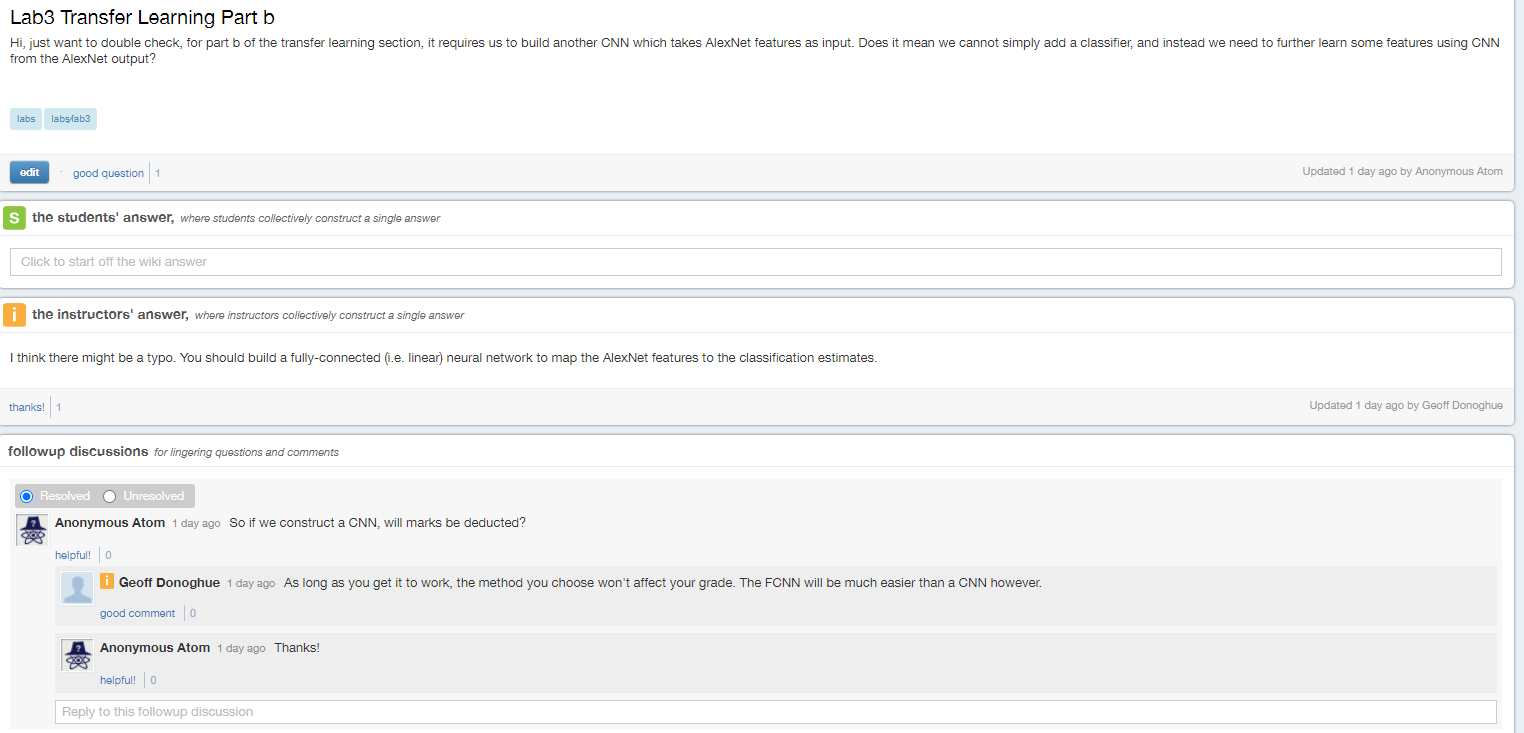

The features coming out of alexNet were 256 by 6 by 6. So I decided to use 4 linear fully connected layers to consolodate that information and lead it to a 9 neuron output layer. More precisely, I had a 9216, 512, 256, and 32 neuron layer before the 9 neuron output layer. I used relu as the activation function due to its simplcity, its disregard for negative values, and its ability to reduce the likelihood of vanishing gradient.  

In [ ]:
# Each batch is torch.Size([32, 256, 6, 6]) so 
# 
class alexCNN(nn.Module):
  def __init__(self):
    super(alexCNN, self).__init__()
    self.fc1 = nn.Linear(256*6*6, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, 9)
    self.name = 'alexCNN'
  
  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
model = alexCNN()
train_loader, val_loader, test_loader = get_alex_data_loader(['A','B','C','D','E','F','G','H','I'], 32, '/content/drive/MyDrive/Colab Notebooks/Alex features/')

if torch.cuda.is_available():
  model.cuda()


loss, train_acc, val_acc = train(model, '/content/drive/MyDrive/Colab Notebooks/Alex features/', batch_size=32, num_epochs=30, learning_rate=0.01)

Loss and accuracy graphs for training, and validation shown below!

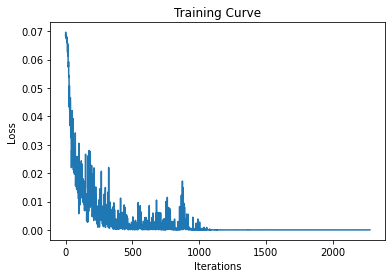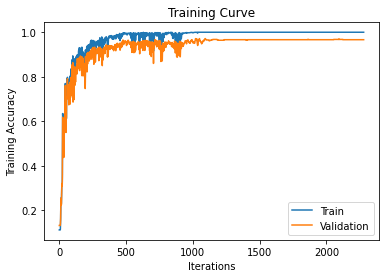

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

Testing accuracy for the alexNet is 97.14%! The transfer learning model destoryed my model by almost a full 20% points of accuracy.


In [ ]:
# Load the saved model and test the accuracy on the testing data
model = alexCNN()
if torch.cuda.is_available():
  model.cuda()

checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Model checkpoint/alexCNN_lr_0.01_bs_32_epc_30.pt')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(get_accuracy(model, train=True))
print(get_accuracy(model, train=False))
print(get_accuracy(model, train='Test'))

1.0
0.966501240694789
0.9714993804213135


### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures. 

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

In [ ]:
# Unzip my own small ASL dataset
!unzip '/content/drive/My Drive/Colab Notebooks/Small data gestures.zip' -d '/root/datasets'

In [ ]:
# Get a dataloader for the small data gesture set
path = '/root/datasets/Small data gestures'

# Some important constants...
data_dir = path
classes = ['A','B','C','D','E','F','G','H','I']
np.random.seed(1000)

# Make sure everything is 224x224, mostly because I'm an idiot and 
# uploaded 244x244 images instead 
transformation = transforms.Compose([transforms.CenterCrop(224), transforms.ToTensor()])

# all_images contains the entire data set, but we want to segment it 
# out into training, validation, and testing...
trainset = datasets.ImageFolder(data_dir, transform=transformation)

# Let's start by getting all of the indices of the images and then randomly
# assigning them to train, val, and test
relevant_indices = get_relevant_indices(trainset, classes, target_classes)
np.random.shuffle(relevant_indices)
relevent_test_indices = relevant_indices

# Get the testing samples
test_sampler = SubsetRandomSampler(relevent_test_indices)
test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            num_workers =0, sampler=test_sampler)

In [ ]:
# Now pass that small data set through alexNet.features and save them to 
# gdrive
classes = ['A','B','C','D','E','F','G','H','I']

# For each input and label batch run it through the alexnet features
folder = '/content/drive/MyDrive/Colab Notebooks/Small DS features/'
i = 0

for i, data in enumerate(test_loader, 0) :
  input, label = data

  test_features = alexnet.features(input)
  features = torch.from_numpy(test_features.detach().numpy())

  sample_path = folder + str(classes[label]) 
  if not os.path.isdir(sample_path):
    os.mkdir(sample_path) 

  torch.save(features.squeeze(0), sample_path + '/' + str(i) + "_" + classes[label] + '.tensor')
  i+=1

In [ ]:
# Get a dataloader for the small data gesture set after it goes through the alex
# feature model
path = '/content/drive/MyDrive/Colab Notebooks/Small DS features'

# Some important constants...
data_dir = path
classes = ['A','B','C','D','E','F','G','H','I']
np.random.seed(1000)

# all_images contains the entire data set, but we want to segment it 
# out into training, validation, and testing...
trainset = datasets.DatasetFolder(data_dir, extensions=('.tensor'), loader=torch.load)

# Let's start by getting all of the indices of the images and then randomly
# assigning them to train, val, and test
relevant_indices = get_relevant_indices(trainset, classes, target_classes)
np.random.shuffle(relevant_indices)
relevent_test_indices = relevant_indices

# Get the testing samples
test_sampler = SubsetRandomSampler(relevent_test_indices)
test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                            num_workers =0, sampler=test_sampler)

In [ ]:
model = alexCNN()
if torch.cuda.is_available():
  model.cuda()

checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Model checkpoint/alexCNN_lr_0.01_bs_32_epc_30.pt')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(get_accuracy(model, train='Test'))

After running my small data set through the alexNet model I got an accuracy of 96.29%. So the model only failed one out of twenty-seven cases which is pretty good. It predicted an 'I' but my hand was actually an 'F':<br> <br>

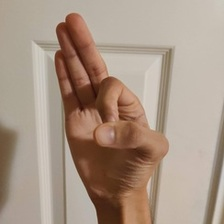


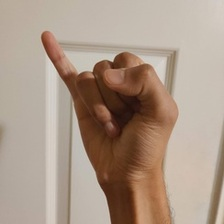

However, I think this is my fault, my hands are just a bit awkward. That being said the two signs are very similar to one another, and when I examined the prediction the two both had a very close estimate 10.4251 for 'F' and 10.4631 for 'I'. Other than that small hiccup, the model performed as expected and had far better results than that of the model made from scratch.   